In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['11111']
ACTIVITIES = ['sit', 'walk', 'upstairs']
SAMPLING_RATE = 100  # Hz
OVERLAP = 0.5
CHUNK_SIZE = 1  # seconds
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
EMB_SIZE = 128
NHEAD = 8
NHID = 128
NLAYERS = 3
DROPOUT = 0.1

In [2]:
def fetch_c2st_data():
    """Fetch data for C2ST with labels: Before=0, After=1."""
    data_raw, labels_raw = [], []

    data_ref = db.collection("data")
    for treatment_doc in data_ref.stream():
        treatment_name = treatment_doc.id
        print(f"Treatment: {treatment_name}")

        for patient_id in INCLUDE_ONLY:
            print(f"  Patient: {patient_id}")
            subject_ref = data_ref.document(treatment_name).collection(patient_id)

            for activity in ACTIVITIES:
                activity_ref = subject_ref.document(activity)
                phone_location_col = activity_ref.collections()

                for phone_location in phone_location_col:
                    location_name = phone_location.id
                    print(f"    Activity: {activity}")
                    print(f"      Phone Location: {location_name}")

                    for recording in phone_location.stream():
                        record = recording.to_dict()
                        if 'acceleration' not in record:
                            continue

                        df = pd.DataFrame(record['acceleration'])
                        timestamps = df['timestamp']
                        min_time = timestamps.min()
                        max_time = timestamps.max()

                        # Exclude first and last 2.5 seconds
                        df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                        if df.empty:
                            continue

                        combined = pd.DataFrame({
                            'ax': df['accelerometer'].apply(lambda x: x['x']),
                            'ay': df['accelerometer'].apply(lambda x: x['y']),
                            'az': df['accelerometer'].apply(lambda x: x['z']),
                            'gx': df['gyroscope'].apply(lambda x: x['x']),
                            'gy': df['gyroscope'].apply(lambda x: x['y']),
                            'gz': df['gyroscope'].apply(lambda x: x['z']),
                        })

                        label = 0 if treatment_name == 'BeforeTreatment' else 1
                        data_raw.append(combined)
                        labels_raw.append(label)

    return data_raw, labels_raw

def prepare_c2st_chunks(data_raw, labels_raw, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    """Chunk data into windows with labels."""
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))

    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(labels_raw[i])
    return np.array(data), np.array(labels)

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [4]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=EMB_SIZE, nhead=NHEAD, nhid=NHID, nlayers=NLAYERS, nclasses=2, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.classifier = nn.Linear(emb_size, nclasses)
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.classifier(x)
        return x

In [5]:
def train_c2st_classifier():
    print("Fetching Before and After data for C2ST...")
    data_raw, labels_raw = fetch_c2st_data()
    X_all, y_all = prepare_c2st_chunks(data_raw, labels_raw, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    print(f"Total data chunks: {X_all.shape}")

    # Split into train/test (both classes present in each)
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        scheduler.step()

        train_acc = correct / total * 100
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # Evaluate on test
    model.eval()
    correct, total, all_preds, all_labels = 0, 0, [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    test_acc = correct / total * 100
    print(f"\nTest Accuracy (C2ST): {test_acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=["Before", "After"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Before", "After"], yticklabels=["Before", "After"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Classifier Two-Sample Test Confusion Matrix")
    plt.show()

Fetching Before and After data for C2ST...
Treatment: AfterTreatment
  Patient: 11111
    Activity: sit
      Phone Location: DominantWrist
    Activity: walk
      Phone Location: DominantWrist
    Activity: upstairs
      Phone Location: DominantWrist
Treatment: BeforeTreatment
  Patient: 11111
    Activity: sit
      Phone Location: DominantWrist
    Activity: walk
      Phone Location: DominantWrist
    Activity: upstairs
      Phone Location: DominantWrist
Total data chunks: (437, 100, 6)


c:\users\yuanh\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30 | Train Loss: 0.6758 | Train Acc: 57.59%
Epoch 2/30 | Train Loss: 0.4715 | Train Acc: 73.93%
Epoch 3/30 | Train Loss: 0.3875 | Train Acc: 78.51%
Epoch 4/30 | Train Loss: 0.3287 | Train Acc: 82.52%
Epoch 5/30 | Train Loss: 0.2532 | Train Acc: 85.96%
Epoch 6/30 | Train Loss: 0.2452 | Train Acc: 88.83%
Epoch 7/30 | Train Loss: 0.1710 | Train Acc: 92.84%
Epoch 8/30 | Train Loss: 0.2152 | Train Acc: 91.12%
Epoch 9/30 | Train Loss: 0.2227 | Train Acc: 87.97%
Epoch 10/30 | Train Loss: 0.1961 | Train Acc: 91.12%
Epoch 11/30 | Train Loss: 0.2034 | Train Acc: 91.40%
Epoch 12/30 | Train Loss: 0.2520 | Train Acc: 87.97%
Epoch 13/30 | Train Loss: 0.2289 | Train Acc: 88.83%
Epoch 14/30 | Train Loss: 0.1775 | Train Acc: 92.84%
Epoch 15/30 | Train Loss: 0.1431 | Train Acc: 93.12%
Epoch 16/30 | Train Loss: 0.1253 | Train Acc: 93.98%
Epoch 17/30 | Train Loss: 0.1623 | Train Acc: 92.26%
Epoch 18/30 | Train Loss: 0.1022 | Train Acc: 95.42%
Epoch 19/30 | Train Loss: 0.1307 | Train Acc: 92.26%
Ep

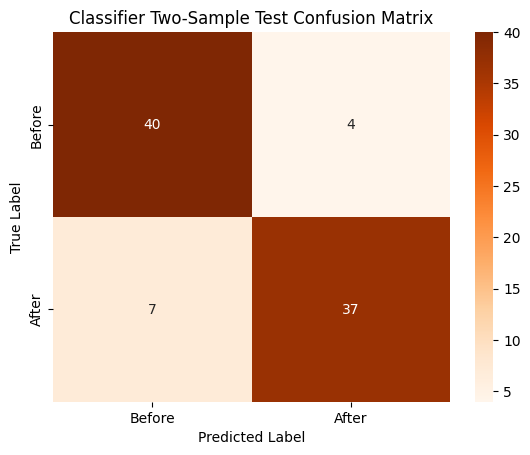

In [6]:
if __name__ == "__main__":
    train_c2st_classifier()